### **Import dependencies**

In [1]:
import random
import tensorflow as tf
import keras
import cv2
from keras.applications import MobileNetV3Small, MobileNetV3Large
from keras.models import Model
from keras import layers, backend, metrics
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Lambda
import math
import os
import numpy as np

In [2]:
len(tf.config.list_physical_devices('GPU'))

1

In [3]:
POS_PATH = '/face-recognition/data/positive/'
NEG_PATH = '/face-recognition/data/negative/'
ANC_PATH = '/face-recognition/data/anchor/'

In [39]:
!tar xf lfw.tgz

In [41]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_path = os.path.join('lfw', directory, file)
        NEW_path = os.path.join(NEG_PATH, file)
        os.replace(EX_path, NEW_path)

### **Collecting anchor/postive image**

In [2]:
import cvlib as cv
import cv2
import uuid

webcam = cv2.VideoCapture(0)

while webcam.isOpened():
    ret, frame = webcam.read()
    if not ret:
        print("Error: failed to capture image")
        break

    frame = cv2.flip(frame, 1)
    cv2.putText(
        frame,
        "Press 'a' to collect anchor image 'p' for positive image and 'q' for quit",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        (0, 255, 0),
        2,
    )
    # face detection
    face, confidence = cv.detect_face(frame)

    for idx, f in enumerate(face):
        (startX, startY) = f[0], f[1]
        (endX, endY) = f[2], f[3]

        # draw rectangle over face
        cv2.rectangle(
            frame, (startX - 15, startY - 15), (endX + 15, endY + 15), (0, 255, 0), 2
        )

        text = "{:.2f}%".format(confidence[idx] * 100)

        Y = startY - 10 if startY - 10 > 10 else startY + 10

        # write confidence percentage on top of face rectangle

        cv2.putText(
            frame, text, (startX, Y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2
        )
        
        print(f"startX: {startX}, startY: {startY}, endX: {endX}, endY: {endY}")
        # Collect anchor image
        if cv2.waitKey(1) & 0xFF == ord("a"):
            cv2.putText(
                frame,
                "Collecting anchor images",
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                (0, 255, 0),
                2,
            )
            img_name = os.path.join("data", "anchor", f"{uuid.uuid1()}.jpg")
            cv2.imwrite(img_name, frame[startY - 14: endY + 14, startX - 14 :endX + 14])
        # Collect positive image
        if cv2.waitKey(1) & 0xFF == ord("p"):
            cv2.putText(
                frame,
                "Collecting positive images",
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                (0, 255, 0),
                2,
            )
            img_name = os.path.join("data", "positive", f"{uuid.uuid1()}.jpg")
            cv2.imwrite(img_name, frame[startY - 14: endY + 14, startX - 14 :endX + 14])


    cv2.imshow("Data Collecting", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

webcam.release()
cv2.destroyAllWindows()

startX: 205, startY: 214, endX: 297, endY: 318
startX: 210, startY: 216, endX: 297, endY: 323
startX: 210, startY: 217, endX: 296, endY: 323
startX: 210, startY: 217, endX: 296, endY: 323
startX: 210, startY: 218, endX: 296, endY: 323
startX: 210, startY: 218, endX: 296, endY: 324
startX: 210, startY: 218, endX: 296, endY: 325
startX: 210, startY: 219, endX: 296, endY: 325
startX: 210, startY: 219, endX: 296, endY: 325
startX: 211, startY: 219, endX: 296, endY: 325
startX: 211, startY: 220, endX: 296, endY: 325
startX: 210, startY: 220, endX: 297, endY: 326
startX: 211, startY: 220, endX: 296, endY: 326
startX: 210, startY: 220, endX: 296, endY: 326
startX: 210, startY: 220, endX: 296, endY: 326
startX: 210, startY: 220, endX: 296, endY: 326
startX: 211, startY: 219, endX: 297, endY: 326
startX: 211, startY: 219, endX: 297, endY: 327
startX: 211, startY: 219, endX: 297, endY: 327
startX: 211, startY: 219, endX: 297, endY: 326
startX: 211, startY: 219, endX: 297, endY: 326
startX: 211, 

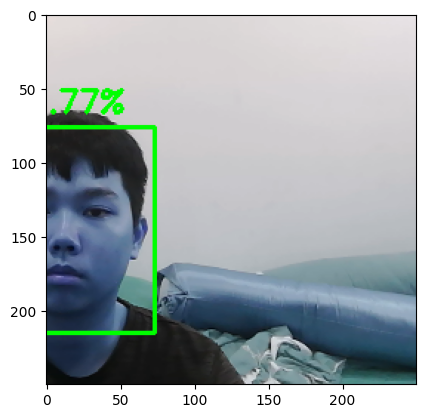

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(frame[120:120+250, 250:250+250, :])

### **Data Augmentation**

In [4]:
def image_augmentation(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, 0.1, seed=(1, 2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1, 3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(0, 100), np.random.randint(0, 100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(0, 100), np.random.randint(0, 100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9, upper=1, seed=(np.random.randint(0, 100), np.random.randint(0, 100)))
        data.append(img)
    return data

In [5]:
import os 
import uuid
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
img_path = os.path.join(ANC_PATH, '5c2f676a-321b-11ee-8bac-2c33585ee515.jpg')
img = cv2.imread(img_path)
augmented_img = image_augmentation(img)

for image in augmented_img:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [34]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_img = image_augmentation(img)
    for image in augmented_img:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid4())), image.numpy())

In [6]:
import os
import glob

anchor_path = os.path.abspath(ANC_PATH)
anchor = tf.data.Dataset.list_files(glob.glob(anchor_path + '/*.jpg')).take(150)
positive_path = os.path.abspath(POS_PATH)
positive = tf.data.Dataset.list_files(glob.glob(positive_path + '/*.jpg')).take(150)
negative_path = os.path.abspath(NEG_PATH)
negative = tf.data.Dataset.list_files(glob.glob(negative_path + '/*.jpg')).take(150)

In [7]:
dir_test= anchor.as_numpy_iterator()

In [11]:
dir_test.next()

b'd:\\face-recognition\\data\\anchor\\5c10719d-321b-11ee-8285-2c33585ee515.jpg'

### **Preprocessing Images - Scale and Resize**

In [12]:
def preprocess(path):
    # Read in image from file path
    byte_img = tf.io.read_file(path)
    # Load in the image
    img = tf.image.decode_jpeg(byte_img, channels=3)
    
    img = tf.image.resize(img, (100, 100))
    
    img = img / 255.0
    
    return img

In [16]:
img = preprocess('/face-recognition/data/anchor/2ef68aa7-329e-11ee-a804-2c33585ee515.jpg')

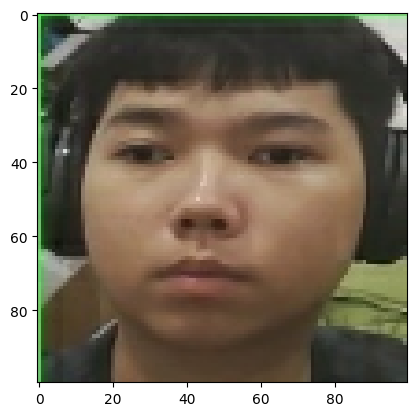

In [17]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [18]:
img.numpy().max()

0.92286503

### **Create labelled dataset**

In [19]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

In [20]:
data = positives.concatenate(negatives)

In [21]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

### **Build Train and Test partition**

In [22]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [23]:
preprocess_twin(*data.as_numpy_iterator().next())

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.13405137, 0.93181485, 0.13250431],
         [0.16178629, 0.84008396, 0.17460392],
         [0.25709218, 0.76394117, 0.29093528],
         ...,
         [0.3498451 , 0.8139039 , 0.34508038],
         [0.34892157, 0.81298035, 0.34415683],
         [0.34892157, 0.81298035, 0.34415683]],
 
        [[0.22704354, 0.8338859 , 0.25142038],
         [0.09279529, 0.56875217, 0.12332942],
         [0.23078825, 0.5294549 , 0.27837646],
         ...,
         [0.64260787, 0.8544118 , 0.62717646],
         [0.64260787, 0.8544118 , 0.62717646],
         [0.6449855 , 0.85678947, 0.6295541 ]],
 
        [[0.30033922, 0.76571566, 0.3550059 ],
         [0.18220001, 0.50856465, 0.2331804 ],
         [0.33350983, 0.45394117, 0.38657844],
         ...,
         [0.76812744, 0.7714608 , 0.74978435],
         [0.7680392 , 0.77137256, 0.7518883 ],
         [0.7683157 , 0.77164906, 0.7489608 ]],
 
        ...,
 
        [[0.3325745 , 0.76747644

In [24]:
# Build dataloader pipeline

data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1000)

In [25]:
# Training partition
train_data = data.take(round(len(data)*0.8))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [26]:
# Testing partition
test_data = data.skip(round(len(data)*0.8))
test_data = test_data.take(round(len(data)*0.2))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

### **Model Engineering**

**Build Embedding Layer**

In [27]:
from keras.layers import Layer, Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD, RMSprop, Adam

In [28]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [29]:
embedding = make_embedding()

In [30]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

**Build Distance Layer**

In [31]:
class L1Dist(keras.layers.Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

**Make siamese model**

In [32]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [33]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [34]:
siamese_layer = L1Dist()

In [35]:
distances = siamese_layer(inp_embedding, val_embedding)

In [36]:
classifier = Dense(1, activation='sigmoid')(distances)

In [37]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>

In [38]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [39]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [40]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [41]:
siamese_model = make_siamese_model()

In [42]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

### **Training**

In [43]:
binary_cross_loss = tf.keras.losses.BinaryCrossentropy()

In [44]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [45]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=optimizer, siamese_model=siamese_model)

Build Train Step Function

In [46]:
test_batch = train_data.as_numpy_iterator()

In [47]:
batch_1 = test_batch.next()

In [48]:
X = batch_1[:2]

In [49]:
y = batch_1[2]

In [50]:
y

array([0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.],
      dtype=float32)

In [51]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    optimizer.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [52]:
from tensorflow.keras.metrics import Precision, Recall

In [53]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [54]:
EPOCHS = 50

In [55]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
15/15 [==============================] - 7s 92ms/step
0.14762703 0.96694213 0.9212598

 Epoch 2/50
15/15 [==============================] - 1s 90ms/step
0.009249247 0.9579832 0.9661017

 Epoch 3/50
15/15 [==============================] - 1s 90ms/step
0.030675339 0.9834711 0.97540987

 Epoch 4/50
15/15 [==============================] - 1s 90ms/step
0.2896989 0.98245615 0.973913

 Epoch 5/50
15/15 [==============================] - 1s 90ms/step
0.08177787 0.96638656 0.9913793

 Epoch 6/50
15/15 [==============================] - 1s 90ms/step
0.030004438 1.0 1.0

 Epoch 7/50
15/15 [==============================] - 1s 90ms/step
0.0415145 1.0 0.99159664

 Epoch 8/50
15/15 [==============================] - 1s 90ms/step
0.017023036 1.0 1.0

 Epoch 9/50
15/15 [==============================] - 1s 90ms/step
0.00029163703 1.0 1

### **Evaluate Model**

In [56]:
from keras.metrics import Precision, Recall

In [57]:
test_input, test_val, ytrue = test_data.as_numpy_iterator().next()

In [58]:
# Make predictions

yhat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 12ms/step


In [59]:
yhat

array([[9.9996567e-01],
       [1.1523078e-09],
       [3.1783966e-05],
       [4.2659733e-11],
       [4.6983414e-06],
       [5.8943544e-10],
       [7.4209026e-08],
       [4.7866572e-11],
       [3.8554103e-12],
       [7.0621042e-10],
       [7.5238015e-05],
       [1.0000000e+00],
       [5.7909633e-10],
       [1.0000000e+00],
       [9.9998736e-01],
       [9.9711275e-01]], dtype=float32)

In [60]:
# Post propresing: siamese_model_post.ipynb

[1 if prediction > 0.5 else 0 for prediction in yhat]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1]

In [61]:
ytrue

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.],
      dtype=float32)

In [62]:
def calculate_precision_recall(ytrue, yhat):
    """
    Calculates the recall score for a given set of true and predicted labels.

    Args:
    - ytrue: numpy array of true labels
    - yhat: numpy array of predicted labels

    Returns:
    - recall_score: float value of the recall score
    """
    r = Recall()
    p = Precision()
    p.update_state(ytrue, yhat)
    precision_score = p.result().numpy()
    r.update_state(ytrue, yhat)
    recall_score = r.result().numpy()
    return (recall_score, precision_score)

calculate_precision_recall(ytrue, yhat)

(1.0, 1.0)

**Visualize our result**

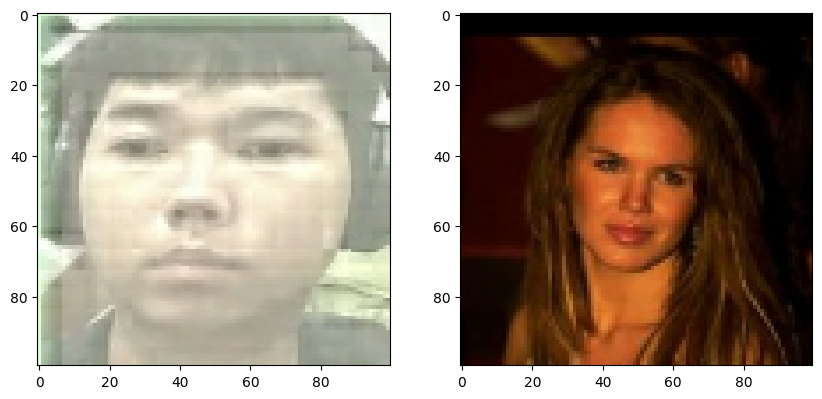

In [63]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(test_input[10])
plt.subplot(1, 2, 2)
plt.imshow(test_val[2])
plt.show()

In [64]:
siamese_model.save('siamese_model.h5')

In [65]:
L1Dist

__main__.L1Dist

In [66]:
import tensorflow as tf

In [67]:
model = tf.keras.models.load_model('siamese_model.h5', custom_objects={'L1Dist': L1Dist, 'Binary Crossentropy': tf.keras.losses.BinaryCrossentropy})

In [68]:
model.predict([test_input, test_val])

1/1 [==============================] - 0s 53ms/step


array([[9.9996567e-01],
       [1.1523078e-09],
       [3.1783966e-05],
       [4.2659733e-11],
       [4.6983414e-06],
       [5.8943544e-10],
       [7.4209026e-08],
       [4.7866572e-11],
       [3.8554103e-12],
       [7.0621042e-10],
       [7.5238015e-05],
       [1.0000000e+00],
       [5.7909633e-10],
       [1.0000000e+00],
       [9.9998736e-01],
       [9.9711275e-01]], dtype=float32)

In [69]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

### **Real time-testing**

In [70]:
application_path = '/face-recognition/application_data/'

In [74]:
def verify( model, detection_threshold, verification_threshold):
    results = []
    # Get the input image
    for image in os.listdir(os.path.join(application_path, 'verification_image')):
        input_image = preprocess(os.path.join(application_path, 'input_image', 'input_image.jpg'))
        validation_image = preprocess(os.path.join(application_path, 'verification_image', image))
        
        # Get the prediction
        result = model.predict(list(np.expand_dims([input_image, validation_image], axis=1)))
        results.append(result[0][0])
        
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join(application_path, 'verification_image')))
    verified = verification > verification_threshold
    
    return results, verified

In [75]:
# put on real time 
import cvlib as cv
import cv2
import numpy as np
import os

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)
    
    # apply face detection
    face, confidence = cv.detect_face(frame)
    # loop through detected faces
    for idx, f in enumerate(face):
        # get corner points of face rectangle
        (startX, startY) = f[0], f[1]
        (endX, endY) = f[2], f[3]
        # draw rectangle over face
        # crop the detected face region
        
        # expand the region a little bit
        w = endX - startX
        h = endY - startY
        startX = max(0, startX - int(0.1*w))
        endX = min(frame.shape[1], endX + int(0.1*w))
        startY = max(0, startY - int(0.1*h))
        endY = min(frame.shape[0], endY + int(0.1*h))
        face_crop = np.copy(frame[startY:endY,startX:endX])
        cv2.rectangle(frame, (startX,startY), (endX,endY), (0,255,0), 2)
        # put text over face
        cv2.putText(frame, 'Acc: {}'.format(str(confidence[idx])), (startX,startY-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
    
    # verfications trigger
    if cv2.waitKey(1) & 0xFF == ord('v'):
        # save input images to folder
        cv2.putText(frame, 'Input Image Saved', (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
        cv2.imwrite(os.path.join(application_path, 'input_image', 'input_image.jpg'), face_crop)
        # run verification
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
        
        
    cv2.imshow('Real Time Recogonition', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 8ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 9ms/step
False
1/1 [==============================] - 0s 9ms/step
False
1/1 [==============================] - 0s 9ms/step
False
1/1 [==============================] - 0s 11ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 10ms/step
False
1/1 [==============================] - 0s 11ms/step
True


In [91]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][